In [0]:
#CHECK THE CONTENT OF THE DBFS
dbutils.fs.ls("/FileStore/tables")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709126412000),
 FileInfo(path='dbfs:/FileStore/tables/account-model/', name='account-model/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1706712567000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-2.zip', name='accounts-2.zip', size=5297592, modificationTime=1706974309000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1706712510000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activat

In [0]:
#declare a variable called fileroot
fileroot = "clinicaltrial_2023"

In [0]:
import os
os.environ['fileroot'] = fileroot

In [0]:
#Reads the CSV file into an RDD
myRDD1 = sc.textFile("/FileStore/tables/"+fileroot+".csv")

In [0]:
#THIS COMMAND ASSISTS IN DEFINING A FUNCTION DEDICATED TO CLEANING AND TRANSFORMING INDIVIDUAL ROWS WITHIN THE CLINICALTRIAL DATASET
def clean_and_transform(row):
    #THIS AIDS IN ELIMINATING SURPLUS TRAILING COMMAS AND UNNECESARY DOUBLE QUOTES THROUGH THE UTILIZATION OF THE STRIP METHOD.
    cleaned_row = row.strip(",").strip('"')
    #THIS COMMAND FACILITATES THE SPLITTING OF THE ROW BY THE SPECIFIED DELIMITER, WHICH IN THIS CASE IS THE TAB ('\t').
    cleaned_row = cleaned_row.split('\t')

    return cleaned_row

# RDD containing rows with varying column lengths
 
def fill_empty_columns(row):
    # Check if the row has less than 14 columns
    if len(row) < 14:
        # Fill up the remaining columns with empty strings
        row += [''] * (14 - len(row))
    return row

In [0]:
#THIS COMMAND MAP THE CLEAN_AND _TRANSFORM FUNCTION TO myRDDS.
myRDD2 = myRDD1.map(clean_and_transform) \
        .map(fill_empty_columns)\
        .zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0])

myRDD2.take(5)

Out[6]: [['NCT03630471',
  'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India',
  'PRIDE',
  'COMPLETED',
  'Mental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)',
  "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
  'Sangath',
  'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine',
  '250.0',
  'OTHER',
  'INTERVENTIONAL',
  'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT',
  '2018-08-20',
  '2019-02-28'],
 ['NCT05992571',
  'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity',
  '',
  'RECRUITING',
  'Cerebrovascular Function|Cognition',
  'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
  'McMaster University',
  'Alzheimer\'s Society of Brant", Haldimand Norfolk," Hamilton Halton',
  '30.0',
  'OTHER',
  'INTERVENTION

In [0]:
# Function to replace empty strings with None
def replace_empty_with_null(line):
    return [None if field == "" else field for field in line]
 
# Replace empty fields with null values
replace_with_null = myRDD2.map(replace_empty_with_null)

In [0]:
def clean_date(date):
    if len(date) < 8:
        date = date + "-01"
    return date
 
def fill_empty_date(date, default_value):
    return default_value if not date else date
 
# Select the column indices
column_indices = [12, 13]
 
# Clean up the start and completion dates
default_date = "2024-01-01"
 
# First RDD: Fill up empty date columns
myRDD3 = replace_with_null.map(lambda row: [
    fill_empty_date(row[i], default_date) if i in column_indices else row[i] for i in range(len(row))
])
 
# Second RDD: Format the date columns
myRDD4 = myRDD3.map(lambda row: [
    clean_date(row[i]) if i in column_indices else row[i] for i in range(len(row))
])
 
myRDD4.take(5)

Out[8]: [['NCT03630471',
  'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India',
  'PRIDE',
  'COMPLETED',
  'Mental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)',
  "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
  'Sangath',
  'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine',
  '250.0',
  'OTHER',
  'INTERVENTIONAL',
  'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT',
  '2018-08-20',
  '2019-02-28'],
 ['NCT05992571',
  'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity',
  None,
  'RECRUITING',
  'Cerebrovascular Function|Cognition',
  'OTHER: Placebo|DIETARY_SUPPLEMENT: β-OHB',
  'McMaster University',
  'Alzheimer\'s Society of Brant", Haldimand Norfolk," Hamilton Halton',
  '30.0',
  'OTHER',
  'INTERVENTI

In [0]:
#Using Dataframe
from pyspark.sql.types import*

mySchema = StructType([
           StructField("Id", StringType()),
           StructField("Study Title", StringType()),
           StructField("Acronym", StringType()),
           StructField("Status", StringType()),
           StructField("Conditions", StringType()),
           StructField("Interventions", StringType()),
           StructField("Sponsor", StringType()),
           StructField("Collaborators", StringType()),
           StructField("Enrollment", StringType()),
           StructField("Funder Type", StringType()),
           StructField("Type", StringType()),
           StructField("Study Design", StringType()),
           StructField("Start", StringType()),
            StructField("Completion", StringType()),
])


Clinicaltrial_df =spark.createDataFrame(myRDD4, mySchema)

Clinicaltrial_df.show(10)

+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|         Id|         Study Title|   Acronym|            Status|          Conditions|       Interventions|             Sponsor|       Collaborators|Enrollment|Funder Type|          Type|        Study Design|     Start|Completion|
+-----------+--------------------+----------+------------------+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------------+--------------------+----------+----------+
|NCT03630471|Effectiveness of ...|     PRIDE|         COMPLETED|Mental Health Iss...|BEHAVIORAL: PRIDE...|             Sangath|Harvard Medical S...|     250.0|      OTHER|INTERVENTIONAL|Allocation: RANDO...|2018-08-20|2019-02-28|
|NCT05992571|Oral Ketone Monoe...|      null|        RECRUITING|Cerebrovascular 

In [0]:
collect_Id_rdd = Clinicaltrial_df.select("Id")
 
# Count the number of distinct study titles
distinct_study_count = collect_Id_rdd.distinct().count()
 
# Print result
print("Number of Studies: ", distinct_study_count)

Number of Studies:  483422


In [0]:
#Question 2
from pyspark.sql.functions import col
 
type_counts_df = Clinicaltrial_df.select(col("Type").alias("Type")).groupBy("Type").count()
 
# Sorting the result by frequency in descending order
sorted_frequencies_df = type_counts_df.orderBy("count", ascending=False)
 
sorted_frequencies_df.show()


+---------------+------+
|           Type| count|
+---------------+------+
| INTERVENTIONAL|371382|
|  OBSERVATIONAL|110221|
|EXPANDED_ACCESS|   928|
|           null|   891|
+---------------+------+



In [0]:
#Question 3
from pyspark.sql.functions import split, explode, col, lit
 
# Split the string by '|' delimiter if it's not empty
# Then, explode the resulting array into separate rows
# Finally, count the occurrences of each element
conditions_df = Clinicaltrial_df.select(Clinicaltrial_df['Id'], Clinicaltrial_df['Conditions']) \
                             .filter(col('Conditions').isNotNull() & (col('Conditions') != '')) \
                             .withColumn('Conditions', split(col('Conditions'), '\|')) \
                             .withColumn('Conditions', explode(col('Conditions'))) \
                             .groupBy('Conditions').count()
 
# Sort the DataFrame by count in descending order
sorted_df = conditions_df.orderBy(col('count').desc())
 
# Take the top 5 rows from the sorted DataFrame
top_5_rows = sorted_df.limit(5)
 
# Show the top 5 elements
top_5_rows.show()

+-------------+-----+
|   Conditions|count|
+-------------+-----+
|      Healthy| 9731|
|Breast Cancer| 7502|
|      Obesity| 6549|
|       Stroke| 4071|
| Hypertension| 4020|
+-------------+-----+



In [0]:
pharma_data = spark.read.csv("/FileStore/tables/pharma.csv", header=False)
 
# Rename the column
pharma_df = pharma_data.withColumnRenamed("_c1", "Parent_company")
 
# Left Anti Join to find entries that exist in Clinical Trial Sponsor but not in Pharma Companies
filtered_df = Clinicaltrial_df.join(pharma_df, Clinicaltrial_df.Sponsor == pharma_df.Parent_company, "left_anti")
 
# Count occurrences again after filtering
result_df = filtered_df.groupBy("Sponsor").count()
 
# Sort the result in descending order of counts
sorted_result_df = result_df.orderBy("count", ascending=False)
 
# Take the top 10 records
top_10_sponsors = sorted_result_df.limit(10)
 
top_10_sponsors.show()
 

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3410|
|   Assiut University| 3335|
|    Cairo University| 3023|
|Assistance Publiq...| 2951|
|         Mayo Clinic| 2766|
|M.D. Anderson Can...| 2702|
|Novartis Pharmace...| 2393|
|National Institut...| 2340|
|Massachusetts Gen...| 2263|
|National Taiwan U...| 2181|
+--------------------+-----+



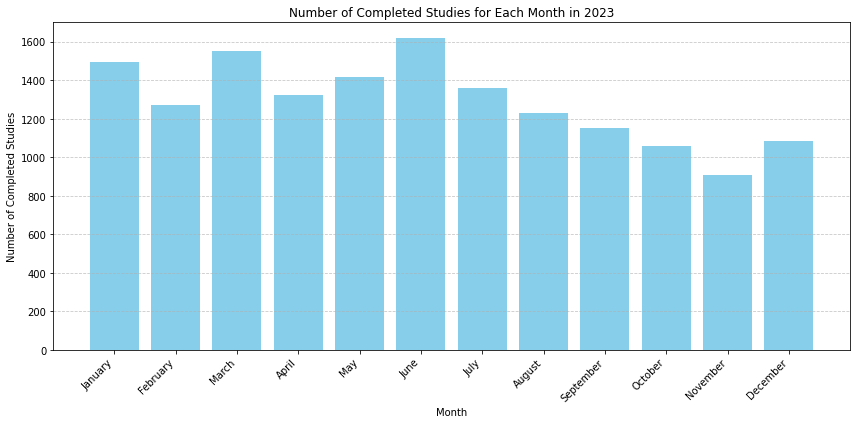

Month			Completed Studies
January                 1494
February                1272
March                   1552
April                   1324
May                     1415
June                    1619
July                    1360
August                  1230
September               1152
October                 1058
November                909
December                1082


In [0]:
#Q5 IMPLEMEMTATION IN RDD
import matplotlib.pyplot as plt
from pyspark.sql.functions import month, year, to_date
import calendar
 
# Define completion date and status filters
completion_year = 2023
completion_status = 'COMPLETED'
 
# Filter the DataFrame to include only rows with the correct number of fields
filtered_df = Clinicaltrial_df.filter(Clinicaltrial_df['Status'] == completion_status) \
                          .filter(year('Completion') == completion_year)
# Convert the completion column to a date format
formatted_df = filtered_df.withColumn('Completion', to_date('Completion', 'yyyy-MM-dd'))
 
# Group by month and count completed studies for each month
completed_studies_by_month = formatted_df.groupBy(month('Completion').alias('month')) \
                                         .count() \
                                         .orderBy('month') \
                                         .collect()
 
# Convert the result to a dictionary
completed_studies_by_month_dict = {row['month']: row['count'] for row in completed_studies_by_month}
 
# Plotting
months = range(1, 13)
study_counts = [completed_studies_by_month_dict.get(month, 0) for month in months]
 
# Convert month numbers to month names
month_names = [calendar.month_name[month] for month in months]
 
plt.figure(figsize=(12, 6))
plt.bar(month_names, study_counts, color='skyblue')
plt.title('Number of Completed Studies for Each Month in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
 
# Table of values
print("Month\t\t\tCompleted Studies")
for month in range(1, 13):
    count = completed_studies_by_month_dict.get(month, 0)
    print(f"{calendar.month_name[month]:<24}{count}")